Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2244383406.py:264: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))
Training Epoch 1:   0%|          | 0/406 [00:00<?, ?it/s]/tmp/ipython-input-2244383406.py:279: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):
Training Epoch 2:   0%|          | 0/406 [00:00<?, ?it/s]/tmp/ipython-input-2244383406.py:279: FutureWarning: `torch.cu

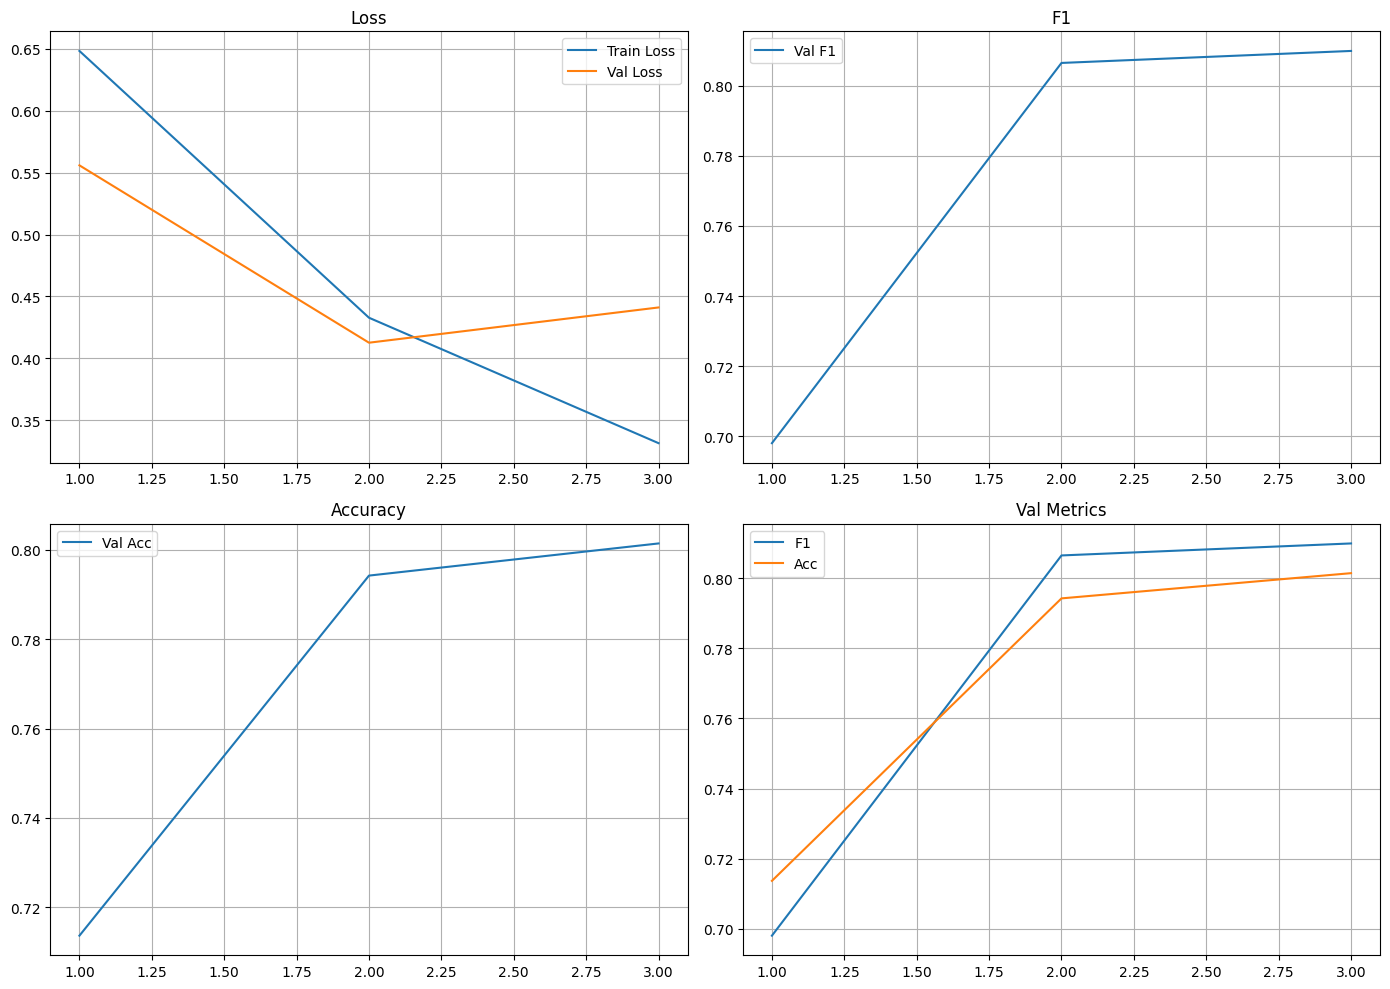


                 precision    recall  f1-score   support

HALLUCINATED(0)       0.80      0.78      0.79       348
     FACTUAL(1)       0.79      0.80      0.79       348

       accuracy                           0.79       696
      macro avg       0.79      0.79      0.79       696
   weighted avg       0.79      0.79      0.79       696



In [2]:
# ==============================================
# Colab Training Script (uses your .env values inline)
# ==============================================

!pip install -q transformers datasets scikit-learn python-dotenv tqdm matplotlib

import os, json, warnings, re
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any, Dict, List

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
)

from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.exceptions import UndefinedMetricWarning

import logging
from tqdm import tqdm
import matplotlib.pyplot as plt

# =========================
# Inline ".env" configuration (your values)
# =========================
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset.json"
MODEL_NAME   = "distilbert-base-uncased"
BATCH_SIZE   = 8
LEARNING_RATE= 2e-5
EPOCHS       = 3
PATIENCE     = 3

# Where to save checkpoints and final model (into Drive so they persist)
CHECKPOINT_DIR = "/content/drive/MyDrive/Colab Notebooks/NewCheckPoints/hallucination_detector_checkpoints"
FINAL_DIR      = "/content/drive/MyDrive/Colab Notebooks/NewBestModelNew/hallucination_detector_final"

# =========================
# (Optional) Mount Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')

# =========================
# Logging
# =========================
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("_main_")

# =========================
# Dataset
# =========================
class HallucinationDataset(Dataset):
    """
    Returns raw fields so the collator can do dynamic pair tokenization.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "question": str(row.get("question", "")),
            "answer": str(row.get("answer", "")),
            "evidence": str(row.get("evidence", "")) if pd.notna(row.get("evidence", "")) else "",
            "label": int(row.get("label", 0)),
        }

class PairCollator:
    """
    Dynamic padding; uses (left: question [+ evidence]), (right: answer).
    DistilBERT ignores token_type_ids, but paired inputs still help boundaries/truncation.
    """
    def __init__(self, tokenizer, max_length=256, use_evidence=True):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_evidence = use_evidence

    def __call__(self, batch):
        lefts, rights, labels = [], [], []
        for b in batch:
            q = b["question"] if isinstance(b["question"], str) else ""
            e = b.get("evidence", "")
            if self.use_evidence and isinstance(e, str) and e.strip():
                left = f"Q: {q}  EVIDENCE: {e}"
            else:
                left = q
            right = b["answer"] if isinstance(b["answer"], str) else ""
            lefts.append(left)
            rights.append(right)
            labels.append(int(b["label"]))

        enc = self.tokenizer(
            lefts, rights,
            truncation=True,
            max_length=self.max_length,
            padding=True,                # dynamic padding
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
        }

# =========================
# Data Preprocessor
# =========================
class DataPreprocessor:
    def load_merged_dataset(self, dataset_path: str) -> pd.DataFrame:
        if not Path(dataset_path).exists():
            raise FileNotFoundError(f"Dataset file not found at: {dataset_path}")
        with open(dataset_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.DataFrame(data)

        # Basic checks
        required = ["question", "answer", "label"]
        for col in required:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in dataset")

        if "evidence" not in df.columns:
            df["evidence"] = ""

        # Clean types
        df["question"] = df["question"].astype(str)
        df["answer"]   = df["answer"].astype(str)
        df["evidence"] = df["evidence"].fillna("").astype(str)
        df["label"]    = df["label"].astype(int)

        logger.info(f"Loaded dataset with {len(df)} samples")
        logger.info(f"Columns: {list(df.columns)}")

        if "source" in df.columns:
            logger.info(f"Source distribution: {df['source'].value_counts().to_dict()}")

        dist = df["label"].value_counts().to_dict()
        logger.info(f"Label distribution: {dist}")
        logger.info(f"  Label 1 (Factual): {dist.get(1,0)} samples ({dist.get(1,0)/len(df)*100:.1f}%)")
        logger.info(f"  Label 0 (Hallucinated): {dist.get(0,0)} samples ({dist.get(0,0)/len(df)*100:.1f}%)")

        # Drop exact-NA rows
        before = len(df)
        df = df.dropna()
        logger.info(f"Dataset after cleaning: {len(df)} samples (dropped {before-len(df)})")
        return df

    def stratified_split(self, df: pd.DataFrame, train=0.7, val=0.15, test=0.15):
        assert abs(train + val + test - 1.0) < 1e-6, "Splits must sum to 1.0"
        X = df.drop(columns=["label"])
        y = df["label"]
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(val+test), stratify=y, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=test/(val+test), stratify=y_temp, random_state=42
        )
        train_df = pd.concat([X_train, y_train], axis=1)
        val_df   = pd.concat([X_val, y_val], axis=1)
        test_df  = pd.concat([X_test, y_test], axis=1)

        logger.info(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
        logger.info(f"Val size:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
        logger.info(f"Test size:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
        for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
            logger.info(f"{name} class distribution: {d['label'].value_counts(normalize=True).to_dict()}")
        return train_df, val_df, test_df

# =========================
# Trainer
# =========================
class HallucinationDetectorTrainer:
    def __init__(self, model_name=MODEL_NAME, max_length=256):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
            id2label={0: "HALLUCINATED", 1: "FACTUAL"},
            label2id={"HALLUCINATED": 0, "FACTUAL": 1},
        ).to(self.device)

        # tracking
        self.train_losses, self.val_losses = [], []
        self.val_f1_scores, self.val_accuracies = [], []
        self.best_f1, self.patience_counter = 0.0, 0

    def create_loaders(self, train_df, val_df, test_df, batch_size=BATCH_SIZE):
        train_ds = HallucinationDataset(train_df)
        val_ds   = HallucinationDataset(val_df)
        test_ds  = HallucinationDataset(test_df)

        self.collator = PairCollator(self.tokenizer, max_length=self.max_length, use_evidence=True)

        pin = (self.device.type == "cuda")
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                  collate_fn=self.collator, pin_memory=pin, num_workers=2)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                  collate_fn=self.collator, pin_memory=pin, num_workers=2)
        test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                  collate_fn=self.collator, pin_memory=pin, num_workers=2)
        return train_loader, val_loader, test_loader

    def setup_optim(self, train_loader, epochs=EPOCHS, lr=LEARNING_RATE):
        self.optimizer = AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        warmup = max(1, int(0.1 * total_steps))  # 10% warmup
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=warmup, num_training_steps=total_steps
        )
        return epochs, lr

    def _metrics(self, logits: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
        preds = np.argmax(logits, axis=1)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1, zero_division=0)
        acc = accuracy_score(labels, preds)
        # AUC (safe)
        try:
            probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
            auc = roc_auc_score(labels, probs)
        except ValueError:
            auc = float("nan")
        return {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "auc": float(auc)}

    @torch.no_grad()
    def _validate(self, val_loader):
        self.model.eval()
        total_loss, outs, labs = 0.0, [], []
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch["input_ids"].to(self.device)
            attn      = batch["attention_mask"].to(self.device)
            labels    = batch["labels"].to(self.device)

            outputs = self.model(input_ids=input_ids, attention_mask=attn, labels=labels)
            total_loss += outputs.loss.item()
            outs.append(outputs.logits.detach().cpu().numpy())
            labs.append(labels.detach().cpu().numpy())

        avg_loss = total_loss / max(1, len(val_loader))
        logits = np.concatenate(outs, axis=0)
        labels = np.concatenate(labs, axis=0)
        return avg_loss, self._metrics(logits, labels)

    def train(self, train_loader, val_loader, epochs=EPOCHS, patience=PATIENCE, checkpoint_dir=CHECKPOINT_DIR):
        os.makedirs(checkpoint_dir, exist_ok=True)
        logger.info("Starting training...")
        logger.info(f"Device: {self.device} | Epochs: {epochs} | Patience: {patience}")

        scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))

        for epoch in range(epochs):
            logger.info(f"\nEpoch {epoch+1}/{epochs}")
            self.model.train()
            total_train_loss = 0.0

            progress = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
            for step, batch in enumerate(progress):
                input_ids = batch["input_ids"].to(self.device)
                attn      = batch["attention_mask"].to(self.device)
                labels    = batch["labels"].to(self.device)

                self.optimizer.zero_grad(set_to_none=True)

                with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):
                    outputs = self.model(input_ids=input_ids, attention_mask=attn, labels=labels)
                    loss = outputs.loss

                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                scaler.step(self.optimizer)
                scaler.update()
                self.scheduler.step()

                total_train_loss += loss.item()
                progress.set_postfix({"Loss": f"{loss.item():.4f}", "Avg": f"{total_train_loss/(step+1):.4f}"})

                if step % 100 == 0 and step > 0:
                    logger.info(f"Step {step}: Current loss={loss.item():.4f}")

            avg_train = total_train_loss / max(1, len(train_loader))
            self.train_losses.append(avg_train)

            # Validation
            logger.info("Running validation...")
            avg_val, metrics = self._validate(val_loader)
            self.val_losses.append(avg_val)
            self.val_f1_scores.append(metrics["f1"])
            self.val_accuracies.append(metrics["accuracy"])

            logger.info(f"Epoch {epoch+1} Results:")
            logger.info(f"  Train Loss: {avg_train:.4f}")
            logger.info(f"  Val Loss:   {avg_val:.4f}")
            logger.info(f"  Val Acc:    {metrics['accuracy']:.4f}")
            logger.info(f"  Val Prec:   {metrics['precision']:.4f}")
            logger.info(f"  Val Recall: {metrics['recall']:.4f}")
            logger.info(f"  Val F1:     {metrics['f1']:.4f}")
            logger.info(f"  Val AUC:    {metrics['auc']:.4f}")

            # Save checkpoint (every epoch)
            ckpt_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
            torch.save({
                "epoch": epoch+1,
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "best_f1": self.best_f1,
            }, ckpt_path)
            logger.info(f"Checkpoint saved: {ckpt_path}")

            # Early stopping on F1
            if metrics["f1"] > self.best_f1:
                self.best_f1 = metrics["f1"]
                self.patience_counter = 0
                # also save "best so far"
                self.model.save_pretrained(FINAL_DIR)         # lightweight save
                self.tokenizer.save_pretrained(FINAL_DIR)
                logger.info(f"New best F1. Model snapshot saved to {FINAL_DIR}")
            else:
                self.patience_counter += 1
                if self.patience_counter >= patience:
                    logger.info(f"Early stopping triggered (no F1 improvement in {patience} epoch(s)).")
                    break

        logger.info("Training complete.")
        logger.info(f"Best validation F1: {self.best_f1:.4f}")
        self._plot_history()

    def _plot_history(self, save_path="/content/training_history.png"):
        if len(self.train_losses) == 0:
            return
        epochs = range(1, len(self.train_losses)+1)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,10))
        ax1.plot(epochs, self.train_losses, label="Train Loss"); ax1.plot(epochs, self.val_losses, label="Val Loss"); ax1.legend(); ax1.grid(True); ax1.set_title("Loss")
        ax2.plot(epochs, self.val_f1_scores, label="Val F1"); ax2.legend(); ax2.grid(True); ax2.set_title("F1")
        ax3.plot(epochs, self.val_accuracies, label="Val Acc"); ax3.legend(); ax3.grid(True); ax3.set_title("Accuracy")
        ax4.plot(epochs, self.val_f1_scores, label="F1"); ax4.plot(epochs, self.val_accuracies, label="Acc"); ax4.legend(); ax4.grid(True); ax4.set_title("Val Metrics")
        plt.tight_layout(); plt.savefig(save_path); plt.show()
        logger.info(f"Training history figure saved to {save_path}")

    @torch.no_grad()
    def evaluate(self, loader, name="Test"):
        self.model.eval()
        outs, labs = [], []
        for batch in tqdm(loader, desc=f"Evaluating {name}", leave=False):
            input_ids = batch["input_ids"].to(self.device)
            attn      = batch["attention_mask"].to(self.device)
            labels    = batch["labels"].to(self.device)

            logits = self.model(input_ids=input_ids, attention_mask=attn).logits
            outs.append(logits.detach().cpu().numpy()); labs.append(labels.detach().cpu().numpy())

        logits = np.concatenate(outs, axis=0)
        labels = np.concatenate(labs, axis=0)
        metrics = self._metrics(logits, labels)
        logger.info(f"{name} Results: Acc={metrics['accuracy']:.4f} | Prec={metrics['precision']:.4f} | "
                    f"Rec={metrics['recall']:.4f} | F1={metrics['f1']:.4f} | AUC={metrics['auc']:.4f}")
        # detailed report
        preds = np.argmax(logits, axis=1)
        print("\n" + classification_report(labels, preds, target_names=["HALLUCINATED(0)", "FACTUAL(1)"]))
        return metrics


# =========================
# Main
# =========================
def main():
    # Load dataset
    pre = DataPreprocessor()
    df  = pre.load_merged_dataset(DATASET_PATH)

    # Stratified split (70/15/15)
    train_df, val_df, test_df = pre.stratified_split(df, 0.70, 0.15, 0.15)

    # Trainer
    trainer = HallucinationDetectorTrainer(model_name=MODEL_NAME, max_length=256)
    train_loader, val_loader, test_loader = trainer.create_loaders(train_df, val_df, test_df, batch_size=BATCH_SIZE)
    epochs, lr = trainer.setup_optim(train_loader, epochs=EPOCHS, lr=LEARNING_RATE)

    # Train
    trainer.train(train_loader, val_loader, epochs=epochs, patience=PATIENCE, checkpoint_dir=CHECKPOINT_DIR)

    # Final evaluate on test set (using current/best snapshot on disk)
    trainer.evaluate(test_loader, name="Test")

    # Evaluation and plotting using the trained model from the trainer object
    y_true, y_pred, prob1 = [], [], []
    trainer.model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(trainer.device)
            attn      = batch["attention_mask"].to(trainer.device)
            labels    = batch["labels"].to(trainer.device)
            logits    = trainer.model(input_ids=input_ids, attention_mask=attn).logits
            p1        = torch.softmax(logits, dim=1)[:,1]
            preds     = torch.argmax(logits, dim=1)
            y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy()); prob1.extend(p1.cpu().numpy())

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title("HPM Confusion Matrix (Test)")
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    plt.savefig(os.path.join(CHECKPOINT_DIR, "hpm_confusion_matrix.png"), dpi=200, bbox_inches="tight"); plt.close()
    logger.info(f"Confusion matrix saved to {os.path.join(CHECKPOINT_DIR, 'hpm_confusion_matrix.png')}")


    # ROC curve
    RocCurveDisplay.from_predictions(y_true, prob1)
    plt.title("HPM ROC Curve (Test)")
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    plt.savefig(os.path.join(CHECKPOINT_DIR, "hpm_roc_curve.png"), dpi=200, bbox_inches="tight"); plt.close()
    logger.info(f"ROC curve saved to {os.path.join(CHECKPOINT_DIR, 'hpm_roc_curve.png')}")


    # Save final model again (ensures latest state is persisted)
    Path(FINAL_DIR).mkdir(parents=True, exist_ok=True)
    trainer.model.save_pretrained(FINAL_DIR)
    trainer.tokenizer.save_pretrained(FINAL_DIR)
    logger.info(f"Final model saved to: {FINAL_DIR}")

if __name__ == "__main__":
    main()